## Import lib

In [1]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## Create dataframe

In [2]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/kaggle/input/bean-leaf-lesions-classification/train'
folder_list = os.listdir(train_path)
label_dict = {
    "healthy":0, 
    "angular_leaf_spot":1,
    "bean_rust":2,
}
for i, folder in enumerate(folder_list):
    img_path = os.path.join(train_path, folder)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":folder, "class_id":label_dict[folder]}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)

In [3]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/kaggle/input/bean-leaf-lesions-classification/val'
folder_list = os.listdir(val_path)
for i, folder in enumerate(folder_list):
    img_path = os.path.join(val_path, folder)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":folder, "class_id":label_dict[folder]}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [4]:
train_df.head()

,path,label,class_id
0,/kaggle/input/bean-leaf-lesions-classification...,bean_rust,2
1,/kaggle/input/bean-leaf-lesions-classification...,bean_rust,2
2,/kaggle/input/bean-leaf-lesions-classification...,bean_rust,2
3,/kaggle/input/bean-leaf-lesions-classification...,bean_rust,2
4,/kaggle/input/bean-leaf-lesions-classification...,bean_rust,2


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


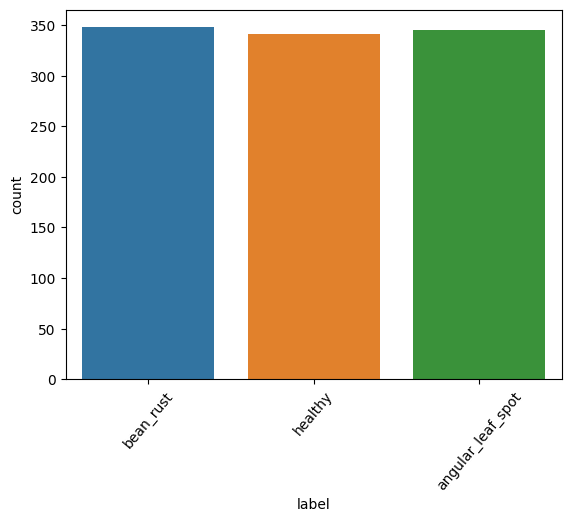

In [5]:
sns.countplot(x = train_df["label"])
plt.xticks(rotation = 50);

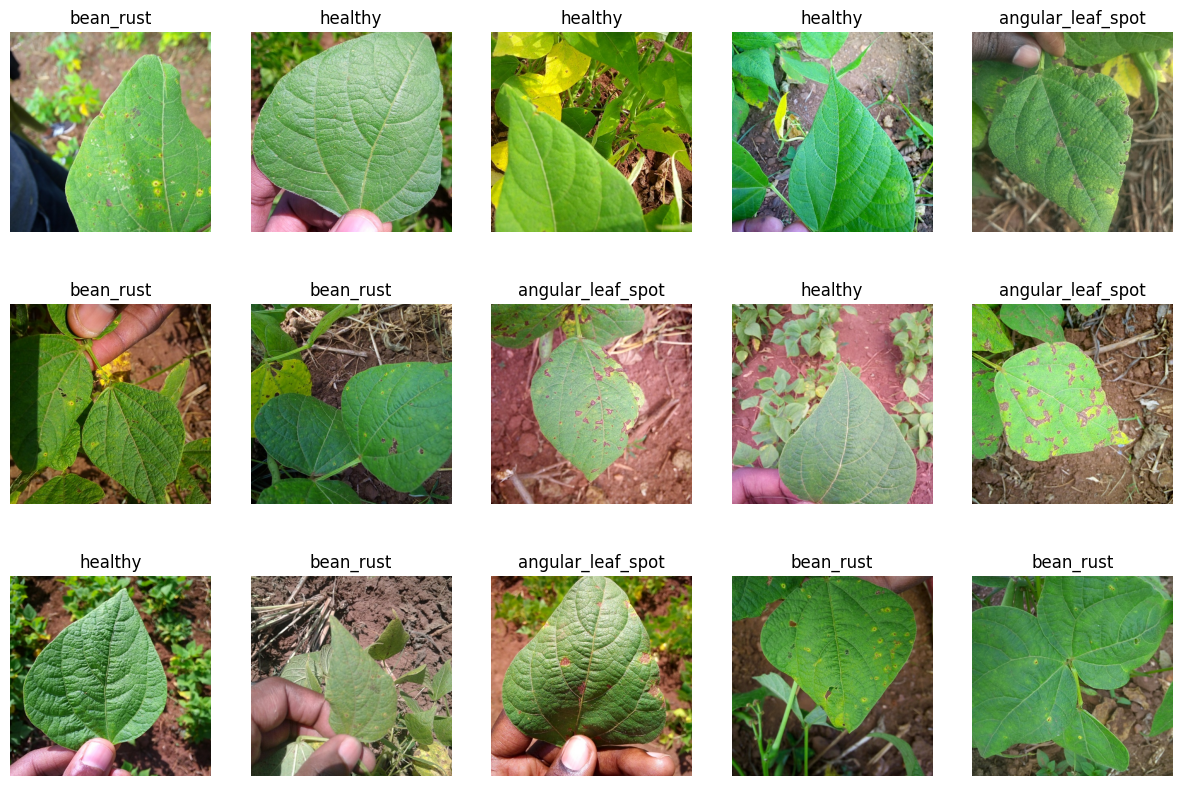

In [6]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Create dataset and dataloader

In [7]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [9]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [10]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:1034
val data:133


## Create model

In [11]:
class_size = 3
# model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
model = models.efficientnet_v2_s(weights='DEFAULT')
# model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(1280, class_size)
model(torch.randn((16,3,256,256))).shape

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 221MB/s]


torch.Size([16, 3])

## Training and validation

In [12]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0 
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        
        # First we'll clean the cache of optimizer
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss 
        loss = loss_fn(outputs,target_)
        
        # Backward propagation
        loss.backward()
        
        # Optimizing model
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0 
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)
            
            # Computing loss 
            loss = loss_fn(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [13]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

criterion  = nn.CrossEntropyLoss()


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.8120, train_acc: 0.692     val_loss: 0.2939, val_acc: 0.925     Learning Rate: 0.0001


  2%|▏         | 1/50 [00:26<22:02, 27.00s/it]

EPOCH: 1     train_loss: 0.3374, train_acc: 0.877     val_loss: 0.2091, val_acc: 0.895     Learning Rate: 0.0001


  4%|▍         | 2/50 [00:45<17:21, 21.71s/it]

EPOCH: 2     train_loss: 0.2209, train_acc: 0.919     val_loss: 0.0405, val_acc: 0.992     Learning Rate: 0.0001


  6%|▌         | 3/50 [01:02<15:38, 19.98s/it]

EPOCH: 3     train_loss: 0.1845, train_acc: 0.938     val_loss: 0.0679, val_acc: 0.977     Learning Rate: 0.0001


  8%|▊         | 4/50 [01:20<14:34, 19.02s/it]

EPOCH: 4     train_loss: 0.1655, train_acc: 0.942     val_loss: 0.0782, val_acc: 0.970     Learning Rate: 0.0001


 10%|█         | 5/50 [01:38<13:55, 18.56s/it]

EPOCH: 5     train_loss: 0.1545, train_acc: 0.940     val_loss: 0.1572, val_acc: 0.955     Learning Rate: 0.0001


 12%|█▏        | 6/50 [01:55<13:23, 18.26s/it]

EPOCH: 6     train_loss: 0.1561, train_acc: 0.939     val_loss: 0.0597, val_acc: 0.985     Learning Rate: 1e-05


 14%|█▍        | 7/50 [02:13<12:55, 18.04s/it]

EPOCH: 7     train_loss: 0.1423, train_acc: 0.957     val_loss: 0.0615, val_acc: 0.977     Learning Rate: 1e-05


 14%|█▍        | 7/50 [02:31<15:28, 21.60s/it]

Earlystop!


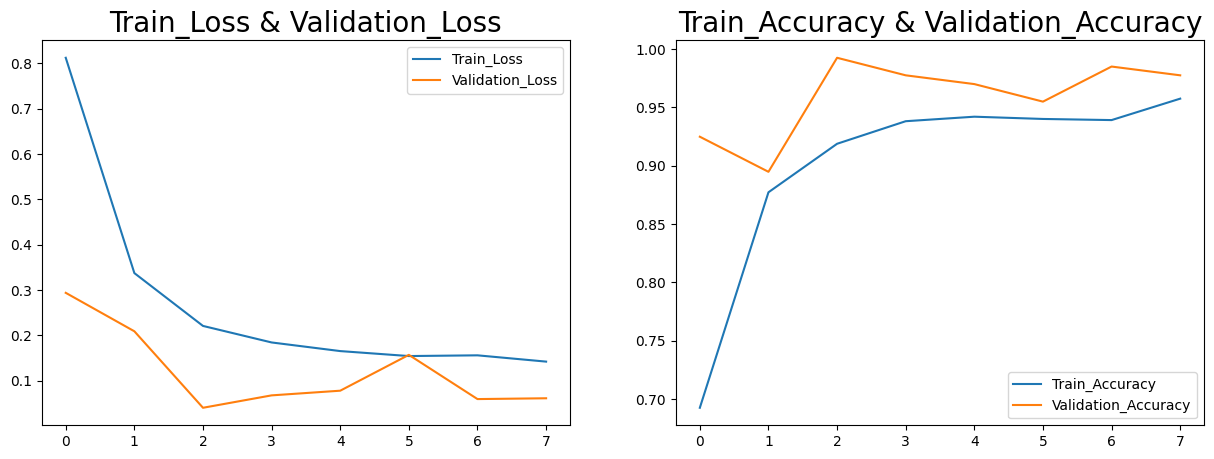

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## Metrics

In [15]:
model.load_state_dict(torch.load('best.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (data_,target_) in tqdm(val_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs,dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


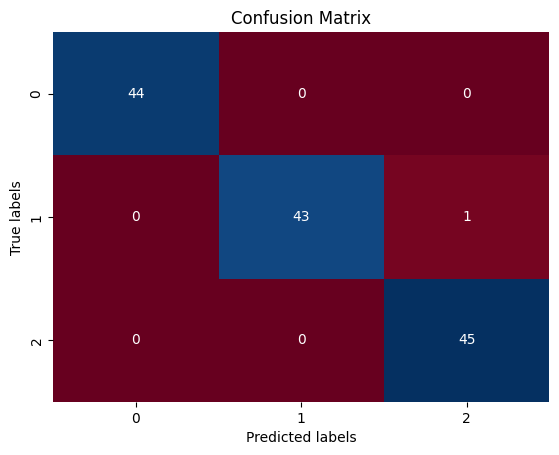

In [16]:
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

In [17]:
target_names = ["healthy", "angular_leaf_spot", "bean_rust"]
clf_report = classification_report(y_true, y_pred, target_names = target_names)
print(clf_report)

                   precision    recall  f1-score   support

          healthy       1.00      1.00      1.00        44
angular_leaf_spot       1.00      0.98      0.99        44
        bean_rust       0.98      1.00      0.99        45

         accuracy                           0.99       133
        macro avg       0.99      0.99      0.99       133
     weighted avg       0.99      0.99      0.99       133



In [18]:
Acc = accuracy_score(y_true,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 99.248%
